# Notebook 2: Preprocessing steps to go from listmode data to preliminary activity information.

In this notebook we will use Python functions to:
- load and inspect the data
- generate an visualizable image
- auto-detect ROI contours
- use events inside ROIs to generate activity decay histogram
- save ROI masks and distributed activity maps to a directory

We will be using an older dataset from the tumors of a mouse treated with 225Ac-DOTA-YS5, an antibody-based alpha-radiopharmaceutical being developed by our colleagues at UCSF.

In [1]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

%load_ext autoreload
%autoreload 2
from iqid import helper as iq
from iqid import process_object as po

pltmap = iq.set_plot_parms()

# Parameters

- binfac: combines (bins) pixels together to increase sensitivity. **In this analysis it is only used to detect contours. The image here is not rebinned, although this can be done.**
- ROI_area_threshold: Minimum area (in pixels) of a sample for auto-segmentation of ROIs. 
- time_binsize: for the decay correction fitting routine. How wide to bin temporal events. 1000 s bin size makes units intuitive, since 1/(1000s) = 1e-3 (1/s) = 1 mBq.
- t_half_life: half-life of Ac-225 for decay correction fitting
- subpx: factor to subpixelize, i.e. increase resolution via linear estimation. subpx=1 means no subpixelization.

In [3]:
binfac = 8
ROI_area_threshold = 500
time_binsize = 1000 # 1e3 s
t_half_life = 9.92 * 24 * 3600 # updated value (2019) from NNDC for Ac-225
subpx = 1

In [4]:
file_name = os.path.join("data_sample", "1_Sample", "01_2021-09-01_16h40m06s.dat")

In [5]:
# import correction and sacrifice times
c_d, ch, cm, sd, sh, sm = np.genfromtxt(os.path.join("data_sample", "1_Sample", 'correction_times.csv'),
                                       delimiter=',',
                                       skip_header=2,
                                       unpack=True)
# the first one in the list corresponds to the dataset we're using
s_corr = 24 * 3600 * c_d + 3600 * ch + 60 * cm
d_sac = sd + sh / 24 + sm / 3600

### A note about SNR of this data

There was a substantial delay in this data which precluded its use in our main analyses due to the low SNR.

In [6]:
# Indicative of the potential for SNR troubles down the road.
print('{:.1f} days between sacrifice and measurement'.format(np.mean(s_corr[:-2]/3600/24)))

36.1 days between sacrifice and measurement


# Generate image from listmode data and parse ROIs (regions of interest)

In [7]:
# custom imshow function to get decent contrast on the image
def my_imshow(im, vmax=0.15):
    plt.imshow(im, cmap='gray', vmax=vmax * np.max(im))
    plt.axis('off')

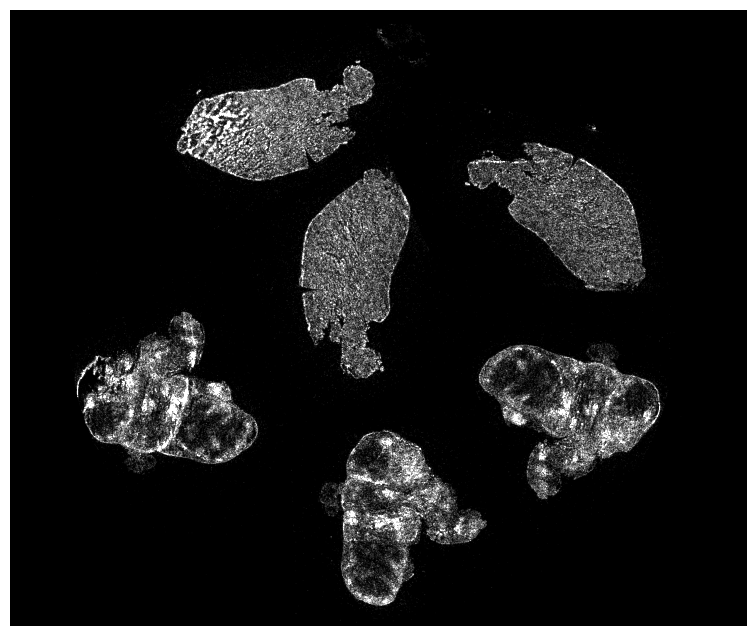

In [8]:
# initialize ClusterData class from iqid/process_object.py code (imported as "po")
# then generate an image from the data using desired subpixelization (none for now)
cdat = po.ClusterData(file_name)
cim = cdat.image_from_listmode(subpx = subpx)

plt.figure(figsize=(10,8))
my_imshow(cim)
plt.show()

C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas\iqid\process_object.py:703: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if idxs == 'all':
Getting ROIs: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 48.93it/s]


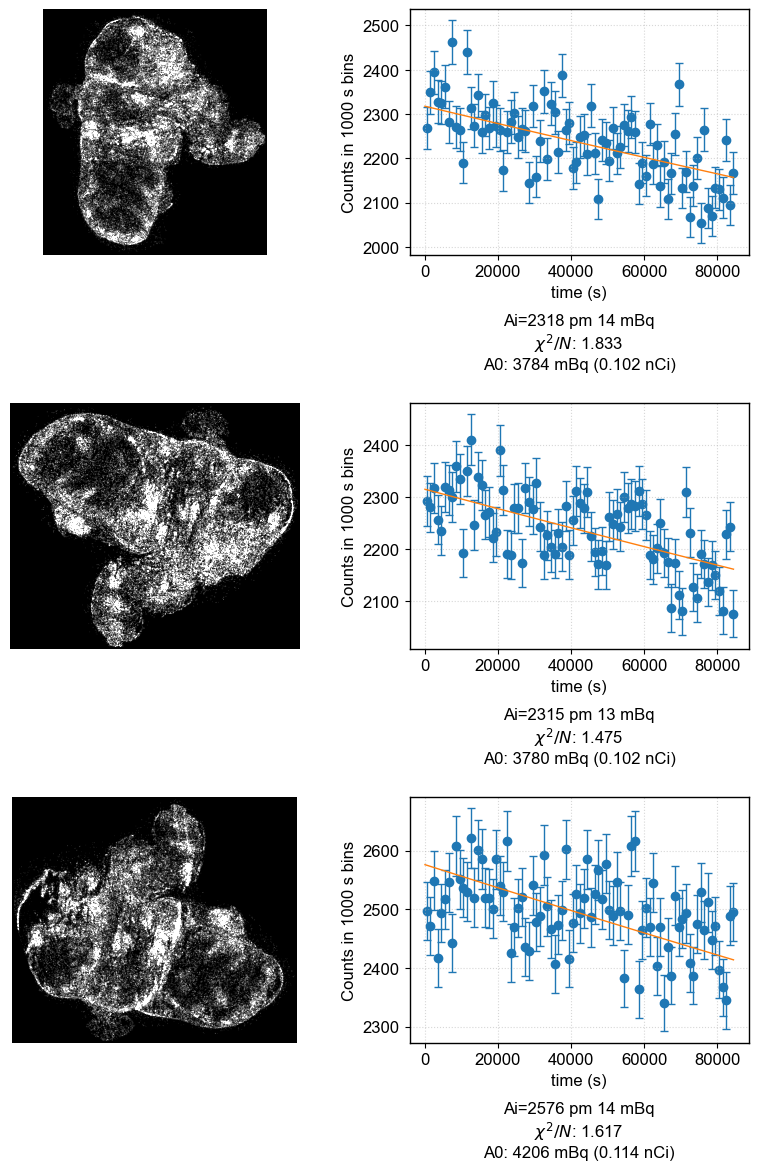

In [9]:
# initialize parameters for processing
_ = cdat.set_process_params(binfac, ROI_area_threshold, time_binsize, t_half_life)
_ = cdat.set_contour_params(gauss=15, thresh=0)
_ = cdat.setup_ROIs(cim)


# apply fitROIs method to identify ROIs and do preprocessing
# used: decay correction, idxs = "only the first three contours", and "do not save masks to a directory"
_, _, f, ax = cdat.fitROIs(cim, 
                     vis=True,
                     corr=s_corr[0], 
                     idxs=np.arange(3), # first three ROIs only (tumors)s
                     save=False,
                     savemasks=False)
plt.tight_layout()
plt.show()

Although this is an autogeneration scheme, you usually need to know what you're asking for to get a good automatic outcome. You may especially need to tune the following parameters:
- time_binsize
- ROI_area_threshold
- idxs (i.e., do "all" to start and then select which ones are actually correct)

If you opt to save the masks and images, they will be automatically saved in the same directory as the .dat files in a new generated folder with the suffix "_Analysis".